# Tabular modeling

In [1]:
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.inspection import plot_partial_dependence
from fastbook import *
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [2]:
creds = '{"username":"harukadoyu","key":"48441f4dcd00985d3bfd5d6dfde354d8"}'

In [3]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()

In [4]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [253]:
Path.BASE_PATH = path

In [254]:
path.ls()

(#18) [Path('bluebook-for-bulldozers.zip'),Path('TrainAndValid.7z'),Path('Data Dictionary.xlsx'),Path('TrainAndValid.zip'),Path('Valid.7z'),Path('Machine_Appendix.csv'),Path('TrainAndValid.csv'),Path('random_forest_benchmark_test.csv'),Path('Test.csv'),Path('median_benchmark.csv')...]

In [255]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [256]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [257]:
sizes = ['Large','Large / Medium','Medium','Small','Mini','Compact']

In [258]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [259]:
dep_var = 'SalePrice'

In [260]:
df[dep_var] = np.log(df[dep_var])

df[dep_var].apply(lambda x: np.log(x))==np.log(df[dep_var])

In [261]:
df.saledate.head()

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: saledate, dtype: object

In [262]:
df = add_datepart(df, 'saledate')

In [263]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [264]:
procs = [Categorify, FillMissing]

In [265]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

In [266]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [267]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [268]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [269]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [270]:
def r_mse(pred, y):
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y): 
    return r_mse(m.predict(xs), y)

In [271]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248593, 0.323441)

In [272]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, min_samples_leaf=min_samples_leaf, max_features=max_features, oob_score=True).fit(xs, y)

In [273]:
m = rf(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170777, 0.233516)

In [274]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/root/mambaforge/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/root/mambaforge/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegr

In [275]:
preds.shape, r_mse(preds.mean(0), valid_y)

((40, 7988), 0.233516)

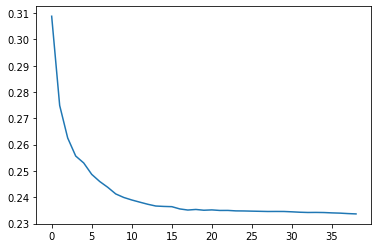

In [276]:
plt.plot([r_mse(preds[:i].mean(0), valid_y) for i in range(1,40)])

In [277]:
r_mse(m.oob_prediction_, y)

0.210553

In [278]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)

In [279]:
fi = rf_feat_importance(m, xs)

<AxesSubplot:ylabel='cols'>

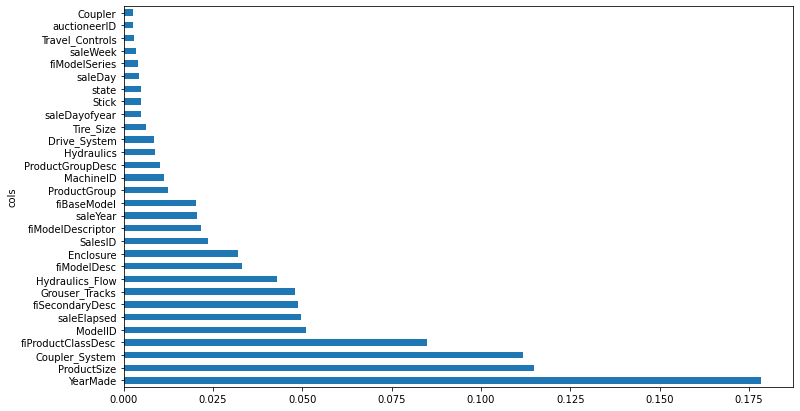

In [280]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

In [281]:
to_keep = fi[fi.imp>0.005].cols
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [282]:
m = rf(xs_imp, y)
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181259, 0.230782)

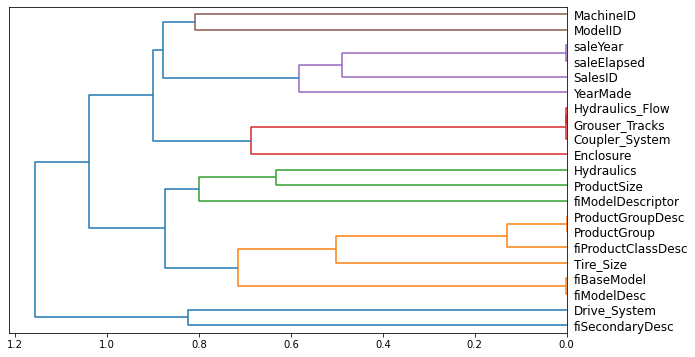

In [283]:
cluster_columns(xs_imp)

In [284]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [285]:
get_oob(xs_imp)

0.8765338703161311

In [286]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8769083995720961,
 'saleElapsed': 0.8722295147107455,
 'ProductGroupDesc': 0.8768361244895492,
 'ProductGroup': 0.8775046835153801,
 'fiModelDesc': 0.875751506653216,
 'fiBaseModel': 0.8769007856999701,
 'Hydraulics_Flow': 0.8775531247398779,
 'Grouser_Tracks': 0.876975636401881,
 'Coupler_System': 0.8773911053411615}

In [287]:
to_drop = ['saleElapsed', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8705096349986681

In [288]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8743550259953543

In [290]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [291]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183335, 0.232208)

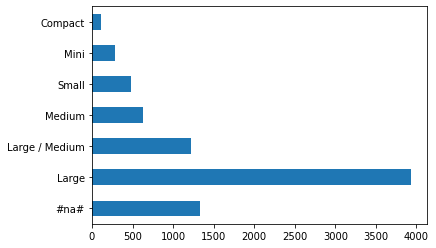

In [292]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

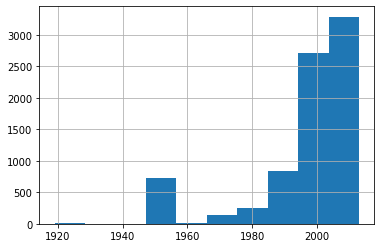

In [293]:
ax = valid_xs_final['YearMade'].hist()

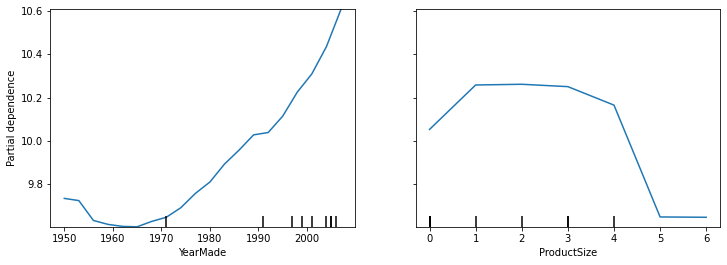

In [294]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

In [295]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [296]:
row = valid_xs_final.iloc[:5]

In [297]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

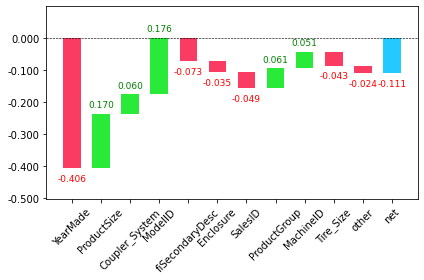

In [298]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

In [299]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.897523
10,SalesID,0.056372
13,MachineID,0.042142
0,YearMade,0.000809
4,ModelID,0.000661
9,Enclosure,0.000461


In [300]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.233434
SalesID 0.230551
saleElapsed 0.235494
MachineID 0.232213


In [301]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228595

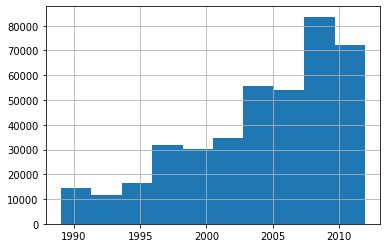

In [302]:
xs['saleYear'].hist();

In [320]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [321]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [322]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [323]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [324]:
cont_nn

['saleElapsed']

In [325]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Hydraulics_Flow          3
fiModelDesc           5059
Enclosure                6
fiModelDescriptor      140
ProductGroup             6
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

In [326]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176734, 0.230339)

In [327]:
cat_nn.remove('fiModelDescriptor')

In [328]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)

In [329]:
dls = to_nn.dataloaders(1024)

In [330]:
y = to_nn.train.y
y.min(), y.max()

(8.465899, 11.863583)

In [332]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0002290867705596611)

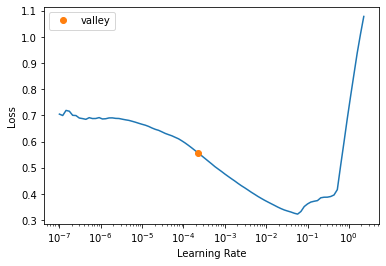

In [333]:
learn.lr_find()

In [334]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.062873,0.064987,00:04
1,0.053909,0.054043,00:04
2,0.047548,0.057976,00:04
3,0.043398,0.050758,00:04
4,0.040261,0.050199,00:04


In [337]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.224052

In [339]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds)/2
r_mse(ens_preds, valid_y)

0.221229